In [1]:
# ! pip install lime
# ! pip install shap
# ! pip install sklearn
# ! pip install xgboost
# ! pip instsall matplotlib seaborn pandas numpy

# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html#Explain-predictions

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import lime
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

import xgboost as xgb
import shap


import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
shap.initjs()

C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# def convert_category(df):
#     df1 = df.copy()
#     for col_name in df.columns:
#         if(df1[col_name].dtype == 'object'):
#             df1[col_name] = df1[col_name].astype('category')
#             df1[col_name] = df1[col_name].cat.codes
#     return df1

def separate_dataset(X, y):
    length = len(X)
    train_length = int(0.8 * length)
    X_train, y_train = X.iloc[:train_length, :], y[:train_length]
    X_test, y_test = X.iloc[train_length:], y[train_length:]
    return X_train, y_train, X_test, y_test

def column_to_onehot(df, field, cats):
    for x in cats:
        df['%s_%s' % (field, x)] = np.zeros(len(df), dtype=np.int32)

    data = df[field].to_numpy()
    for i, x in enumerate(data):
        df.iloc[i, df.columns.get_loc('%s_%s' % (field, x))] = 1
    df.drop(field, inplace=True, axis=1)

def to_onehot(df, excepts):
    df1 = df.copy()
    for col_name in df.columns:
        if not col_name in excepts and df1[col_name].dtype == 'object':
            column_to_onehot(df1, col_name, cats[col_name])
    return df1

**1. Load data**

**1.1 Ecommerce**

An international e-commerce company based wants to discover key insights from their customer database. They want to use some of the most advanced machine learning techniques to study their customers. The company sells electronic products.

Content
The dataset used for model building contained **10999** observations of 12 variables.
The data contains the following information:

- ID: ID Number of Customers.
- Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
- Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
- Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
- Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
- Cost of the product: Cost of the Product in US Dollars.
- Prior purchases: The Number of Prior Purchase.
- Product importance: The company has categorized the product in the various parameter such as low, medium, high.
- Gender: Male and Female.
- Discount offered: Discount offered on that specific product.
- Weight in gms: It is the weight in grams.
- Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

Acknowledgements
I would like to specify that I am only making available on Github in Data collected data about product shipment to Kagglers. I made this as my project on Customer Analytics stored in GitHub repository.

Inspiration
This data of Product Shipment Tracking, answer instantly to your questions:

What was Customer Rating? And was the product delivered on time?
Is Customer query is being answered?
If Product importance is high. having higest rating or being delivered on time?

In [3]:
# # backbone code
ecommerce = pd.read_csv("../data/ecommerce/ecommerce.csv")
# ecommerce['Product_importance'].replace(to_replace=['low', 'medium', 'high'], value=[0, 1, 2], inplace=True)
# ecommerce['Gender'].replace(to_replace=['M', 'F'], value=[1,0], inplace=True)
# column_to_onehot(ecommerce, 'Mode_of_Shipment', ['Flight', 'Ship', 'Road'])
# column_to_onehot(ecommerce, 'Warehouse_block', ['A', 'B', 'C', 'D', 'F'])
# ecommerce['Mode_of_Shipment'].replace(to_replace=['Flight', 'Ship', 'Road'], value=[0, 1, 2], inplace=True)
# ecommerce['Warehouse_block'].replace(to_replace=['A', 'B', 'C', 'D', 'F'], value=[0, 1, 2, 3, 4], inplace=True)
ecommerce.tail(5)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0
10998,10999,D,Ship,2,5,155,5,low,F,6,1639,0


**Problem 1: Rating prediction**

In [33]:
# rating_data = ecommerce.copy()
# rt_corr = rating_data.corr()
# rt_corr.iloc[2:3,:]

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Mode_of_Shipment_Flight,Mode_of_Shipment_Ship,Mode_of_Shipment_Road,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F
Customer_rating,-0.005722,0.012209,1.0,0.00927,0.013179,0.003999,0.002775,-0.003124,-0.001897,0.013119,-0.002481,0.000765,0.001516,-0.010471,-0.003222,0.001093,0.008687,0.003092


In [34]:
# def clean_pred(pred):
#     a = []
#     for x in pred:
#         x = int(x)
#         if x > 5:
#             x = 5
#         if x < 1:
#             x = 1
#         a.append(x)
#     return a

In [6]:
# rating_data = rating_data.sample(frac=1)

In [35]:
# rating_data_y = rating_data.iloc[:,2]
# rating_data_X = rating_data.drop(['Customer_rating', 'ID'], axis=1)

# rating_dict = {v: k for k, v in dict(enumerate(sorted(rating_data_y.unique()))).items()}
# rating_data_y = rating_data_y.map(rating_dict)

In [36]:
# rt_X_train, rt_y_train, rt_X_test, rt_y_test = separate_dataset(rating_data_X, rating_data_y)

**Write your model here**

In [18]:
from pathlib import Path
from collections import defaultdict

def get_ecommerce(data_path, onehot_cols=None, target_feature=None):
    encode_dict = defaultdict()
    ecommerce = pd.read_csv(data_path / 'ecommerce' / 'ecommerce.csv')
    ecommerce.drop(columns=['ID'], inplace=True)
    cols = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_rating', 'Gender', 'Product_importance']
    encode_dict['Product_importance'] = {'low': 0, 'medium': 1, 'high': 2}
    encode_dict['Gender'] = {'M': 0, 'F': 1}
    encode_dict['Mode_of_Shipment'] = {'Flight': 0, 'Ship': 1, 'Road': 2}
    encode_dict['Warehouse_block'] = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'F': 4}
    encode_dict['Customer_rating'] = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
    assert target_feature is not None, 'missing target'
    for c in cols:
        if (onehot_cols is not None) and (c in onehot_cols):
            if target_feature == c:
                ecommerce[c].replace(to_replace=encode_dict[c], inplace=True)
            else:
                df_onehot = pd.get_dummies(ecommerce[c])
                new_cols = f'{c}_' + df_onehot.columns
                df_onehot.rename(columns=dict(zip(df_onehot.columns, new_cols)), inplace=True)
                ecommerce.drop(columns=[c], inplace=True)
                ecommerce = pd.concat([ecommerce, df_onehot], axis=1)
        else:
            ecommerce[c].replace(to_replace=encode_dict[c], inplace=True)
    return ecommerce, encode_dict

def load_rating_data(data_path, onehot_cols=None, target_feature=None):
    rating_data, encode_dict = get_ecommerce(data_path, onehot_cols, target_feature)
    rating_data = rating_data.sample(frac=1)
    rating_data_y = rating_data.loc[:, target_feature]
    cols = [c for c in rating_data.columns if c != target_feature]
    rating_data_X = rating_data.loc[:, cols]

    return rating_data_X, rating_data_y, encode_dict

In [ ]:
# # train a single model: XGBoost

# onehot_cols = [ 'Warehouse_block', 'Mode_of_Shipment']

# rating_data_X, rating_data_y, encode_dict = load_rating_data(
#     data_path=Path('../data'),
#     onehot_cols=onehot_cols,
#     target_feature='Customer_rating'
# )
# rt_X_train, rt_X_test, rt_y_train, rt_y_test = train_test_split(rating_data_X, rating_data_y, test_size=0.2, random_state=8)

# dtrain = xgb.DMatrix(data=rt_X_train, label=rt_y_train)
# dtest = xgb.DMatrix(data=rt_X_test, label=rt_y_test)

# num_rounds = 400
# eval_list = [(dtrain, 'train'), (dtest, 'eval')]

# num_classes = 5
# config = {
#     'max_depth' : 9,
#     'eta' : 0.1, 
#     "min_child_weight": 2,
#     "subsample": 1.0,
#     'objective' : 'multi:softmax',
#     'num_class': num_classes,
#     'eval_metric' : ['mlogloss', 'merror'],
# }
# bst = xgb.train(
#     params=config, 
#     dtrain=dtrain, 
#     num_boost_round=num_rounds, 
#     evals=eval_list,
# )

In [ ]:
! pip install "ray[tune]"

In [19]:
from ray import tune
from ray.tune.integration.xgboost import TuneReportCheckpointCallback

def train_rating(config, checkpoint_dir=None):
    data_path = Path(tune.get_trial_dir()).parent.parent.parent.parent / 'data'
    params = config['params']
    data_cfg = config['data']
    rating_data_X, rating_data_y, _ = load_rating_data(
        data_path, 
        onehot_cols=data_cfg['onehot_cols'], 
        target_feature=data_cfg['target_feature']
    )
    rt_X_train, rt_y_train, rt_X_test, rt_y_test = separate_dataset(rating_data_X, rating_data_y)

    dtrain = xgb.DMatrix(data=rt_X_train, label=rt_y_train)
    dtest = xgb.DMatrix(data=rt_X_test, label=rt_y_test)
    
    num_rounds = 500
    eval_list = [(dtrain, 'train'), (dtest, 'eval')]
    results = {}

    xgb.train(
        params=params, 
        dtrain=dtrain, 
        num_boost_round=num_rounds, 
        evals=eval_list,
        evals_result=results,
        verbose_eval=False,
        early_stopping_rounds=50,
        callbacks=[TuneReportCheckpointCallback(filename='model.xgb')]
    )

def get_best_model_checkpoint(analysis):
    best_trial = analysis.get_best_trial(metric='eval-merror', mode='min', scope='all') 
    best_check_point = analysis.get_best_checkpoint(best_trial, metric='eval-merror', mode='min')
    best_bst = xgb.Booster()
    best_bst.load_model(Path(best_check_point) / 'model.xgb')
    accuracy = 1. - best_trial.last_result['eval-merror']
    print(f"Best model parameters: {best_trial.last_result}")
    print(f"Best model total accuracy: {accuracy:.4f}")
    return best_bst


def run_tune(config):
    analysis = tune.run(
        train_rating,
        resources_per_trial={'cpu': 8, 'gpu': 1},
        config=config,
        num_samples=30,
        name='exp',
        local_dir='./checkpoints/',
        verbose=1
    )
    return analysis

In [20]:
if not (Path() / 'checkpoints').exists():
    (Path() / 'checkpoints').mkdir()
    
config = {
        'params': {
            'max_depth' : tune.randint(6, 9),
            'eta' : tune.loguniform(1e-3, 1e-1), 
            "min_child_weight": tune.choice([2, 3, 4]),
            "subsample": tune.uniform(0.8, 1.0),
            'objective' : 'multi:softmax',
            'num_class': 5,
            'eval_metric' : ['mlogloss', 'merror'],
            'tree_method': 'gpu_hist'
        },
        'data': {
            # 'onehot_cols': [ 'Warehouse_block', 'Mode_of_Shipment', 'Customer_rating', 'Gender', 'Product_importance'],
            # 'onehot_cols': [ 'Warehouse_block', 'Mode_of_Shipment'],
            'onehot_cols': None,
            'target_feature': 'Customer_rating' 
        }
    }

analysis = run_tune(config)

2022-04-19 10:16:26,831	INFO tune.py:639 -- Total run time: 182.87 seconds (182.74 seconds for the tuning loop).


In [21]:
analysis = tune.ExperimentAnalysis('./checkpoints/exp')
best_bst = get_best_model_checkpoint(analysis)

2022-04-19 10:16:27,022	INFO experiment_analysis.py:696 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


Best model parameters: {'train-mlogloss': 1.411712, 'train-merror': 0.370724, 'eval-mlogloss': 1.621632, 'eval-merror': 0.794545, 'time_this_iter_s': 0.03345155715942383, 'done': True, 'timesteps_total': None, 'episodes_total': None, 'training_iteration': 53, 'trial_id': 'e8d41_00028', 'experiment_id': 'c2287189cc01491cb08ada89c47b1196', 'date': '2022-04-19_10-16-20', 'timestamp': 1650330980, 'time_total_s': 2.0986781120300293, 'pid': 10980, 'hostname': 'DESKTOP-NI20RCT', 'node_ip': '127.0.0.1', 'config': {'params': {'max_depth': 8, 'eta': 0.05028839397130115, 'min_child_weight': 3, 'subsample': 0.950270777811149, 'objective': 'multi:softmax', 'num_class': 5, 'eval_metric': ['mlogloss', 'merror'], 'tree_method': 'gpu_hist'}, 'data': {'onehot_cols': None, 'target_feature': 'Customer_rating'}}, 'time_since_restore': 2.0986781120300293, 'timesteps_since_restore': 0, 'iterations_since_restore': 53, 'experiment_tag': '28_eta=0.050288,max_depth=8,min_child_weight=3,subsample=0.95027'}
Best m

In [22]:
rating_data_X, rating_data_y, encode_dict = load_rating_data(
    data_path=Path('../data'),
    onehot_cols=config['data']['onehot_cols'],
    target_feature='Customer_rating'
)
rt_X_train, rt_y_train, rt_X_test, rt_y_test = separate_dataset(rating_data_X, rating_data_y)

dtrain = xgb.DMatrix(data=rt_X_train, label=rt_y_train)
dtest = xgb.DMatrix(data=rt_X_test, label=rt_y_test)

In [23]:
# cannot have better model performance than 20-30 % accuracy on test set
rt_pred_test = best_bst.predict(dtest)
rt_acc_test = accuracy_score(rt_y_test, rt_pred_test)
print(f'Test Accuracy: {rt_acc_test:.4f}')

Test Accuracy: 0.4155


**Initialize explainer here**

### SHAP

Feature Description:

- ID: ID Number of Customers.
- Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
- Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
- Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
- Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
- Cost of the product: Cost of the Product in US Dollars.
- Prior purchases: The Number of Prior Purchase.
- Product importance: The company has categorized the product in the various parameter such as low, medium, high.
- Gender: Male and Female.
- Discount offered: Discount offered on that specific product.
- Weight in gms: It is the weight in grams.
- Reached on time: 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

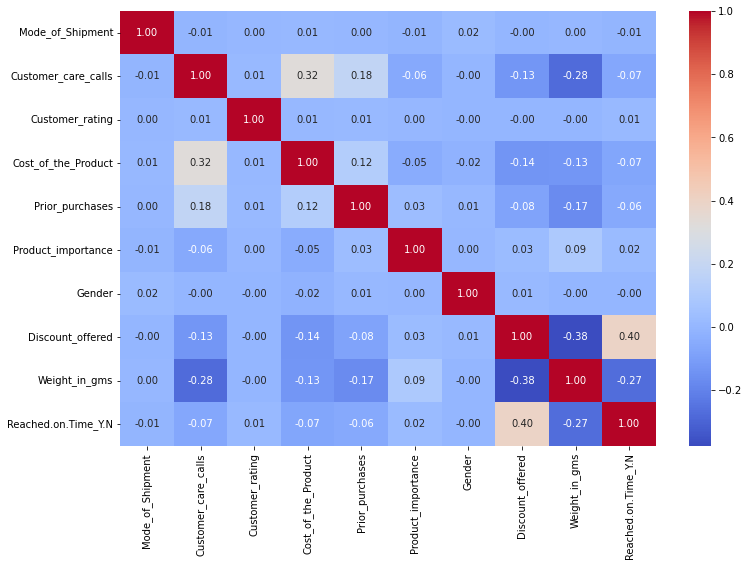

In [24]:
# check the variables are independent
ecommerce, encode_dict = get_ecommerce(
    data_path=Path('../data'),
    onehot_cols=config['data']['onehot_cols'],
    target_feature='Customer_rating'
)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(ecommerce.iloc[:, 1:].corr(), cmap='coolwarm', annot=True, fmt=".2f", ax=ax)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

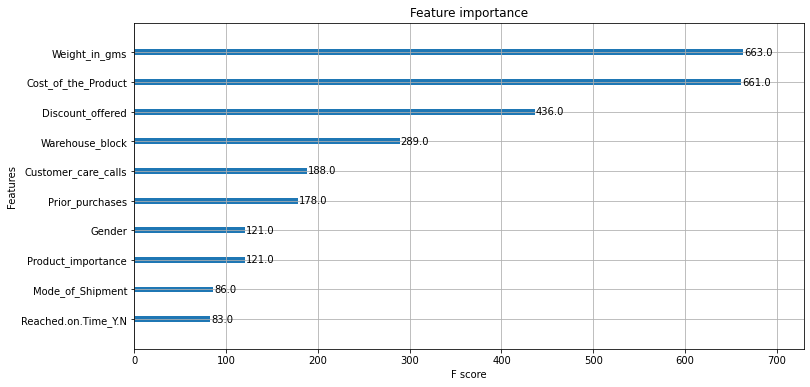

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
xgb.plot_importance(best_bst, ax=ax)

In [41]:
pred_test = best_bst.predict(dtest, output_margin=True)  # predict score
explainer = shap.TreeExplainer(best_bst)
# shape_values for each class: shape (5, N, # of features)
shap_values = np.array(explainer.shap_values(dtest))

addups = np.abs(
    shap_values.sum(-1).T +  # total shape values for each class (N, 5)
    np.tile(np.array(explainer.expected_value), (pred_test.shape[0], 1)) - # expected value: average of the model output over the training data
    pred_test  # predict score for each class (N, 5)
    )
# make sure the SHAP values add up to marginal predictions
print(addups.max(0).round(5))

[0. 0. 0. 0. 0.]


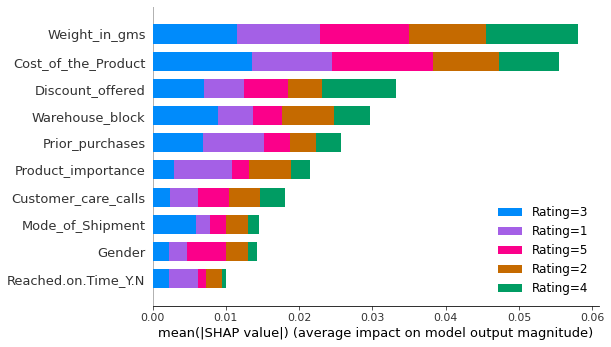

In [42]:
rt_class_inverse = {v: f'Rating={k}' for k, v in encode_dict['Customer_rating'].items()}
shap.summary_plot([x for x in shap_values], rt_X_test, title='Average SHAP value for all classes', class_names=rt_class_inverse)

For all the classes Top 3 features(`Weight_in_gms`, `Cost_of_the_Product`, `Discount_offered`) are most influential features to all classes. 

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
10124,0,2,6,269,6,1,0,4,4423,0
2409,1,1,3,180,2,0,1,6,1811,1
2989,4,2,5,206,4,0,0,62,1137,1
1433,4,1,3,176,3,0,0,51,1297,1
7079,4,1,3,221,3,1,0,7,4741,1
...,...,...,...,...,...,...,...,...,...,...
6152,0,2,3,226,3,0,1,8,4002,0
7451,4,1,4,246,6,0,0,4,1489,0
172,2,1,3,148,3,0,0,56,1550,1
1639,4,0,3,233,3,1,0,1,2744,1


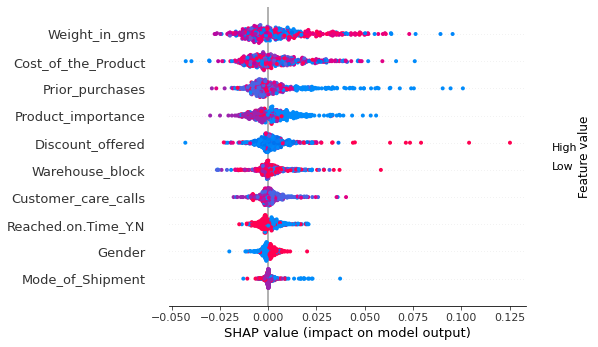

In [63]:
label = 0
idx = (rt_y_test == label).values
shap.summary_plot(shap_values[label][idx], rt_X_test.loc[idx])

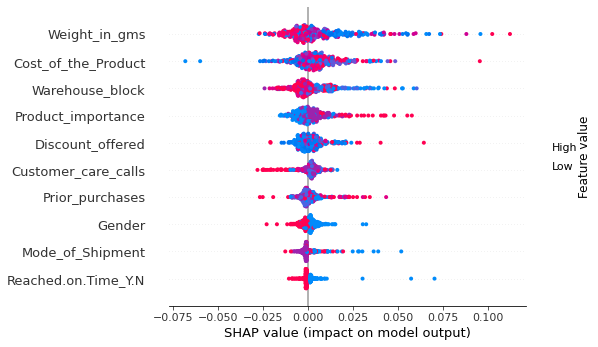

In [64]:
label = 1
idx = (rt_y_test == label).values
shap.summary_plot(shap_values[label][idx], rt_X_test.loc[idx])

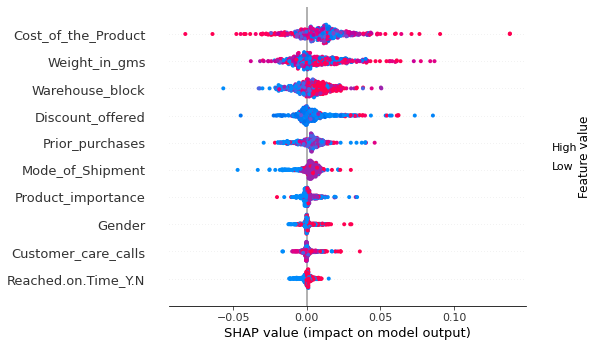

In [65]:
label = 2
idx = (rt_y_test == label).values
shap.summary_plot(shap_values[label][idx], rt_X_test.loc[idx])

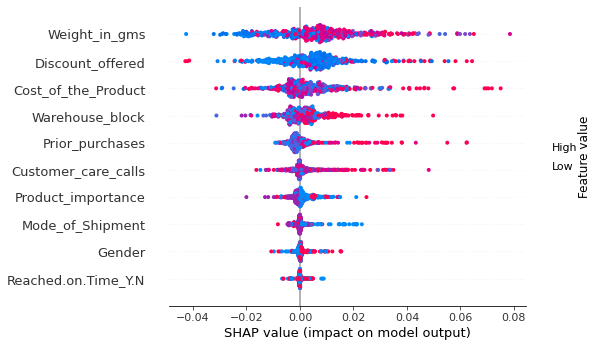

In [66]:
label = 3
idx = (rt_y_test == label).values
shap.summary_plot(shap_values[label][idx], rt_X_test.loc[idx])

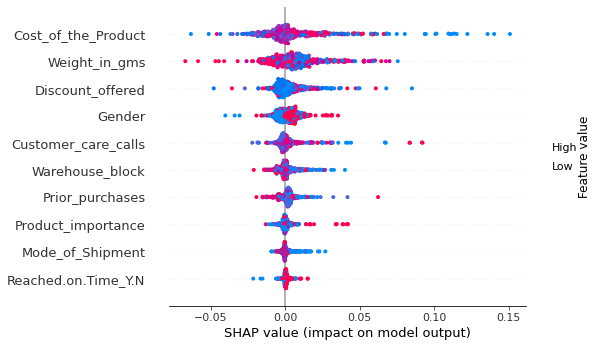

In [67]:
label = 4
idx = (rt_y_test == label).values
shap.summary_plot(shap_values[label][idx], rt_X_test.loc[idx])

In [74]:
idx = np.random.choice(rt_y_test.index, 2)
sample_y = rt_y_test.loc[idx]
sample_X = rt_X_test.loc[idx]

In [73]:
shap.waterfall_plot(shap_values)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
5632,2,0,5,217,2,1,1,3,5925,0
7951,4,0,6,306,4,0,1,8,1465,0


**Problem 2: Reached on time or not**

In [94]:
ecommerce = get_ecommerce(data_path=Path('./data'))
ontime_data = ecommerce.copy()
ontime_data = ontime_data.sample(frac=1)
ontime_data_y = ontime_data.iloc[:,9]
ontime_data_X = ontime_data.drop(['Customer_rating', 'Reached.on.Time_Y.N', 'ID'], axis=1)

In [ ]:
ot_corr = ontime_data.drop(['ID', 'Customer_rating'], axis=1).corr()
ot_corr.iloc[7:8,:]

In [ ]:
ot_X_train, ot_y_train, ot_X_test, ot_y_test = separate_dataset(ontime_data_X, ontime_data_y)

**Implement your classification model here**

In [ ]:
ot_acc = accuracy_score(ot_y_test, ot_pred)
print(ot_acc)

**Initialize classification explainer here**

**1.2 Marketing Champaign in bank**

Abstract:
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

Data Set Information:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

Attribute Information:

Bank client data:
- Age (numeric)
- Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', - 'technician', 'unemployed', 'unknown')
- Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
- Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
- Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
- Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
- Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

Related with the last contact of the current campaign:
- Contact: contact communication type (categorical: 'cellular','telephone')
- Month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
- Dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- Duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Other attributes:
- Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 
- Pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- Previous: number of contacts performed before this campaign and for this client (numeric)
- Poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Social and economic context attributes
- Emp.var.rate: employment variation rate - quarterly indicator (numeric)
- Cons.price.idx: consumer price index - monthly indicator (numeric)
- Cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- Euribor3m: euribor 3 month rate - daily indicator (numeric)
- Nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes', 'no')

Analysis Steps:
Atribute information Analysis.
Machine Learning (Logistic Regression, KNN, SVM, Decision Tree,
Random Forest, Naive Bayes)
Deep Learning (ANN)

Source:
Dataset from : http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

In [ ]:
marketing = pd.read_csv("./data/banking_marketing/bank_data.csv", sep=";")

In [ ]:
marketing['default'] = marketing['default'].replace("unknown", "no")
marketing['housing'] = marketing['housing'].replace("unknown", "no")
marketing['loan'] = marketing['loan'].replace("unknown", "no")

In [ ]:
cats = {}
for c in marketing.columns:
    if marketing[c].dtype == 'object':
        cats[c] = np.sort(marketing[c].unique())

In [ ]:
marketing_onhot = to_onehot(marketing, ['y'])

In [ ]:
marketing_onhot

In [ ]:
marketing_onhot['y'] = marketing_onhot['y'].replace(to_replace=['no', 'yes'], value=[0, 1])

In [ ]:
corr = marketing_onhot.corr()

In [ ]:
corr.iloc[10:11,:]

In [ ]:
marketing_onhot = marketing_onhot.sample(frac=1)
mkt_y = marketing_onhot['y']
mkt_X = marketing_onhot.drop('y', axis=1)

In [ ]:
mkt_X_train, mkt_y_train, mkt_X_test, mkt_y_test = separate_dataset(mkt_X, mkt_y)

**Implement classification model here**

In [ ]:
mkt_pred = mkt_classifier.predict(mkt_X_test)
mkt_acc = accuracy_score(mkt_y_test, mkt_pred)
print(mkt_acc)

**Explainer implementation here**

**1.3 Beijing Housing**

Housing price of Beijing from 2011 to 2017, fetching from Lianjia.com

Content
It includes URL, ID, Lng, Lat, CommunityID, TradeTime, DOM(days on market), Followers, Total price, Price, Square, Living Room, number of Drawing room, Kitchen and Bathroom, Building Type, Construction time. renovation condition, building structure, Ladder ratio( which is the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average), elevator, Property rights for five years（It's related to China restricted purchase of houses policy), Subway, District, Community average price.

- url: the url which fetches the data
- id: the id of transaction
- Lng: and Lat coordinates, using the BD09 protocol.
- Cid: community id
- tradeTime: the time of transaction
- DOM: active days on market.Know more in https://en.wikipedia.org/wiki/Days_on_market
- followers: the number of people follow the transaction.
- totalPrice: the total price
- price: the average price by square
- square: the square of house
- livingRoom: the number of living room
- drawingRoom: the number of drawing room
- kitchen: the number of kitchen
- bathroom the number of bathroom
- floor: the height of the house. I will turn the Chinese characters to English in the next version.
- buildingType: including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).
- constructionTime: the time of construction
- renovationCondition: including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )
- buildingStructure: including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).
- ladderRatio: the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on - average.
- elevator: have ( 1 ) or not have elevator( 0 )
- fiveYearsProperty: if the owner have the property for less than 5 years,

Target column: **totalPrice** (plz remove **price** column from the predictors)

Most data is traded in 2011-2017, some of them is traded in Jan,2018, and some is even earlier(2010,2009)

All the data was fetching from https://bj.lianjia.com/chengjiao.

Acknowledgements
All the data was fetching from Lianjia

Inspiration
It may help you predict the housing price of Beijing.

In [ ]:
from datetime import datetime

In [ ]:
housing = pd.read_csv("./data/housing/beijing_housing_2.csv")

In [ ]:
housing.drop("url", inplace=True, axis=1)

In [ ]:
housing['constructionTime'] = housing['constructionTime'].replace("未知", 'nan')
housing.drop(housing[(housing['constructionTime'] == '1')
                     | (housing['constructionTime'] == '0')
                     | (housing['constructionTime'] == 'nan')].index, inplace=True)
housing['constructionTime'] = housing['constructionTime'].astype('int')

In [ ]:
housing['floor_num'] = housing['floor'].apply(lambda x : x.split(" ")[-1])
housing['floor_type'] = housing['floor'].apply(lambda x : x.split(" ")[0])
housing['floor_num'] = housing['floor_num'].astype('int')
housing.drop('floor', inplace=True, axis=1)
housing.drop(housing[housing['floor_type'] == '未知'].index, inplace=True)

In [ ]:
housing['floor_type'] = housing['floor_type'].replace(to_replace=['顶','高','中','低','底'], value=[5,4,3,2,1])
housing['floor_type'] = housing['floor_type'].astype('int')

In [ ]:
housing['tradeTime'] = housing['tradeTime'].apply(lambda x: int(datetime.timestamp(datetime.strptime(x, "%Y-%m-%d"))))
housing['tradeTime'] = housing['tradeTime'].astype('int')

In [ ]:
housing['livingRoom'] = housing['livingRoom'].astype('int')
housing['drawingRoom'] = housing['drawingRoom'].astype('int')
housing['bathRoom'] = housing['bathRoom'].astype('int')

**Filling missing value of DOM & buildingType**

As you can see, DOM hightly correlates with totalPrice, while buildingType weakly correlates with totalPrice. 

In [ ]:
dom_mean = housing['DOM'].mean()

In [ ]:
dataset = housing.sample(frac=1)
y = dataset.iloc[:,7]
X = dataset.copy()

In [ ]:
X.drop(["id", "Cid", "price", "ladderRatio", "fiveYearsProperty", "totalPrice"], inplace=True, axis=1)

In [ ]:
X['DOM'].fillna(value=dom_mean, inplace=True)

In [ ]:
X_train, y_train, X_test, y_test = separate_dataset(X, y)

**Initialize model & explainer**

In [ ]:
housing_pred = housing_model.predict(X_test)

In [ ]:
housing_mae = mae(y_test, housing_pred)
print(housing_mae)

**Explainer implementation**